In [1]:
import numpy as np
from numpy.polynomial.hermite_e import hermefit, hermeval
import matplotlib.pyplot as plt

## Exercise1.1

In [2]:
# 1.1
# E(Y|X)
def coeffsForCondiExp(X,Y,hermiteOrder):
    return hermefit(X, Y, hermiteOrder)

# beta = coeffsForCondiExp(X,Y,hermiteOrder)

def approxCondExp(X,beta):
    return hermeval(X, beta)

## Exercise2.1

The BSDE is given by:
$$
d Y_{t}=\left[r Y_{t}+\sigma^{-1}(\mu-r) Z_{t}\right] d t+Z_{t} d W_{t}, t \in[0, T], Y_{T}=\xi 
$$

$
\text { where } \xi=\left[S_{T}-K\right]_{+} \text {for } K>0 \text { fixed and } d S_{t}=\mu S_{t} d t+\sigma S_{t} d W_{t}
$

The solution of $S_{t}$ is
$$
S_{t}=S_{0} \exp \left(\left(\mu-\frac{\sigma^{2}}{2}\right) t+\sigma W_{t}\right)
$$


We first simulate the brownian motion and then solve the BSDE numerically

In [3]:
def simulate_BM(S0 = 1, mu = 0.03, sigma = 0.2, T = 1, N = 100, N_mc = 10**3):
    dt = float(T)/N
    t=np.linspace(0,T,N)
    #  initialize the brownian motion
    dW_df = np.zeros((N_mc,N-1))
    W_T = np.zeros(N_mc)
    
    #  initialize the Underlying asset St, N_mc paths,N time points
    S_df = np.zeros((N_mc,N))
    
    #simuliate the brownian motion & St for N_mc paths
    for i in range(N_mc):
        dW=np.sqrt(dt)*np.random.randn(1,N-1)
        dW_df[i] = dW
        
        W=np.cumsum(dW) 
        W_T[i] = W[-1] 
        
        Xtrue=S0*np.exp((mu-0.5*sigma**2)*t[1:]+sigma*W)
        Xtrue=np.insert(Xtrue,0,S0)
        S_df[i] = Xtrue
        
    return dW_df, W_T, S_df

In [4]:
dW_df, W_T, S_df = simulate_BM()

The folowwing is the explicit solution of the BSDE

Our interested BSDE is 
$$
d Y_{t}=\left[r Y_{t}+\sigma^{-1}(\mu-r) Z_{t}\right] d t+Z_{t} d W_{t}, t \in[0, T], Y_{T}=\xi 
$$
Set 
$$
g_{t}(y,z)=ry_{t}+\dfrac{\mu-r}{\sigma}z_{t}, \phi = \dfrac{\mu-r}{\sigma}
$$
Consider the measure $\mathbb{Q}$ given by Radon-Nikodym derivative
$$
\dfrac{d\mathbb{Q}}{d\mathbb{P}}=\exp(-\dfrac{1}{2}\int_{0}^{T}\phi^{2}dt-\int_{0}^{T}\phi dW_{t})=\exp(-\dfrac{T}{2}\phi^{2}-\phi W_{T})
$$
The expectation of the Radon-Nikodym derivative is 1, this can be checked easily. Then due to Girsanov's Theorem we have 
$$
W^{\mathbb{Q}}_{t}=W_{t}+\int_{0}^{t}\phi ds = W_{t} + \phi t
$$
is a $\mathbb{Q}$-Wiener process. 
Consider this BSDE

$$
d\bar{Y}_{t}=\bar{Z}_{t}dW_{t}^{\mathbb{Q}}; \ \bar{Y}_{t} = \bar{\xi}
$$
Where $\bar{\xi} = \xi\exp(-rT)$. 
Let $Y_{t} = \bar{Y}_{t}\exp(rt)$, $\bar{Z}_{t} = Z_{t}\exp(rt)$
By Ito's formula, we have the following:
$$
\begin{aligned}
dY_{t}&=d(\bar{Y}_{t}\exp(rt))\\
&=re^{rt}\bar{Y}_{t}dt+e^{rt}d\bar{Y}_{t}\\
&=rY_{t}dt+Z_{t}dW_{t}^{\mathbb{Q}}
\end{aligned}
$$
Then we can get:
$$
\begin{aligned}
d\mathrm{E}^{\mathbb{Q}}(Y_{t}|\mathcal{F}_{t}) = \mathrm{E}^{\mathbb{Q}}(Y_{t}|\mathcal{F}_{t})rdt\\
\dfrac{d\mathrm{E}^{\mathbb{Q}}(Y_{t}|\mathcal{F}_{t})}{\mathrm{E}^{\mathbb{Q}}(Y_{t}|\mathcal{F}_{t})}=rdt\\
\log(\mathrm{E}^{\mathbb{Q}}(\xi|\mathcal{F}_{t}))-\log(Y_{t})=r(T-t)\\
Y_{t} = \mathrm{E}^{\mathbb{Q}}(\xi e^{(-r(T-t))}|\mathcal{F}_{t})
\end{aligned}
$$
Finally we have: 
$$
\begin{aligned}
Y_{t}&=\dfrac{\mathrm{E}(\xi e^{(-r(T-t))}e^{\left(-\frac{T}{2} \phi^{2}-\phi W_{T}\right)}|\mathcal{F}_{t})}{\mathrm{E}(e^{\left(-\frac{T}{2} \phi^{2}-\phi W_{T}\right)}|\mathcal{F}_{t})}\\
&=\dfrac{\mathrm{E}(\xi e^{(-r(T-t))}e^{\left(-\phi W_{T}\right)}|\mathcal{F}_{t})}{\mathrm{E}(e^{\left(-\phi W_{T}\right)}|\mathcal{F}_{t})}
\end{aligned}
$$

The numerical solution is implemented as:
$$
\begin{array}{l}
Y_{i} \approx \mathbb{E}_{t_{i}}\left[Y_{i+1}-g_{i}\left(Y_{i+1}, Z_{i}\right) \Delta t_{i+1}\right], i=0,1, \ldots, N-1, Y_{N}=\xi \\
Z_{i} \approx \frac{1}{\Delta t_{i+1}} \mathbb{E}_{t_{i}}\left[Y_{i+1} \Delta W_{i+1}\right]
\end{array}
$$

In [5]:
def get_solution_BSDE(S0 = 1, mu = 0.03, sigma = 0.2, T = 1, N = 100, N_mc = 10**3,
                      K = 1, r = 0.01, N_basis_f = 50):
    dt = float(T)/N
    t=np.linspace(0,T,N)
    #  initialize the simulated Yt process
    Y_df = np.zeros((N_mc,N))
    #  initialize the explicit Yt process, it will help us check the 'simulated Yt' convergence to the exact solution
    Ytrue_df = np.zeros((N_mc,N))
    
    #set the initial value Y_T for each path (terminal condition)
    for i in range(N_mc):
        Y_df[i,-1] = max(S_df[i,-1]-K,0)
        Ytrue_df[i,-1] = max(S_df[i,-1]-K,0)##explicit solution
        
    Z_df = np.zeros((N_mc,N-1))
    
    for i in range(N-2,-1,-1):
        #Simulated Yt process
        # according to the iterative formula, estimate the condition value for Z and simulated Y for each time step
        beta_Z = coeffsForCondiExp(S_df[:,i],Y_df[:,i+1]*dW_df[:,i],N_basis_f)
        Z_df[:,i] = approxCondExp(S_df[:,i],beta_Z)/dt
    
        beta_Y = coeffsForCondiExp(S_df[:,i],Y_df[:,i+1] - (r*Y_df[:,i+1] + sigma**(-1)*(mu-r)*Z_df[:,i])*dt,N_basis_f)
        Y_df[:,i] = approxCondExp(S_df[:,i],beta_Y)
        
        #exact process for Yt according to the explicit solution
        beta_Ytrue_denominator = coeffsForCondiExp(S_df[:,i],np.exp(-(mu-r)/sigma*W_T),N_basis_f)
        beta_Ytrue_numerator = coeffsForCondiExp(S_df[:,i],np.exp(-(mu-r)/sigma*W_T)*Y_df[:,-1],N_basis_f)
        Ytrue_df[:,i] = np.exp(-r*(T-dt*(i+1)))*approxCondExp(S_df[:,i],beta_Ytrue_numerator)/approxCondExp(S_df[:,i],beta_Ytrue_denominator)
    return Y_df, Ytrue_df, t, N_mc

In [6]:
Y_df, Ytrue_df, t, N_mc=  get_solution_BSDE()

D:\Anaconda\lib\site-packages\numpy\polynomial\hermite_e.py:1371: RankWarning: The fit may be poorly conditioned
  return pu._fit(hermevander, x, y, deg, rcond, full, w)


Then we solve the BSDE with the parameter settings: $S_0 = 1$, $\mu = 0.03$, $\sigma = 0.2$, $T = 1$, $N = 100$, $N_mc = 1000$,
 $K = 1$, $r = 0.01$, $N_{\text{basis}} = 50$
 
 We can change the parameters just simply rerun the function defined above and change the input.

Next we randomly select the sample path calculated previously to make a comparison with the exact solution.

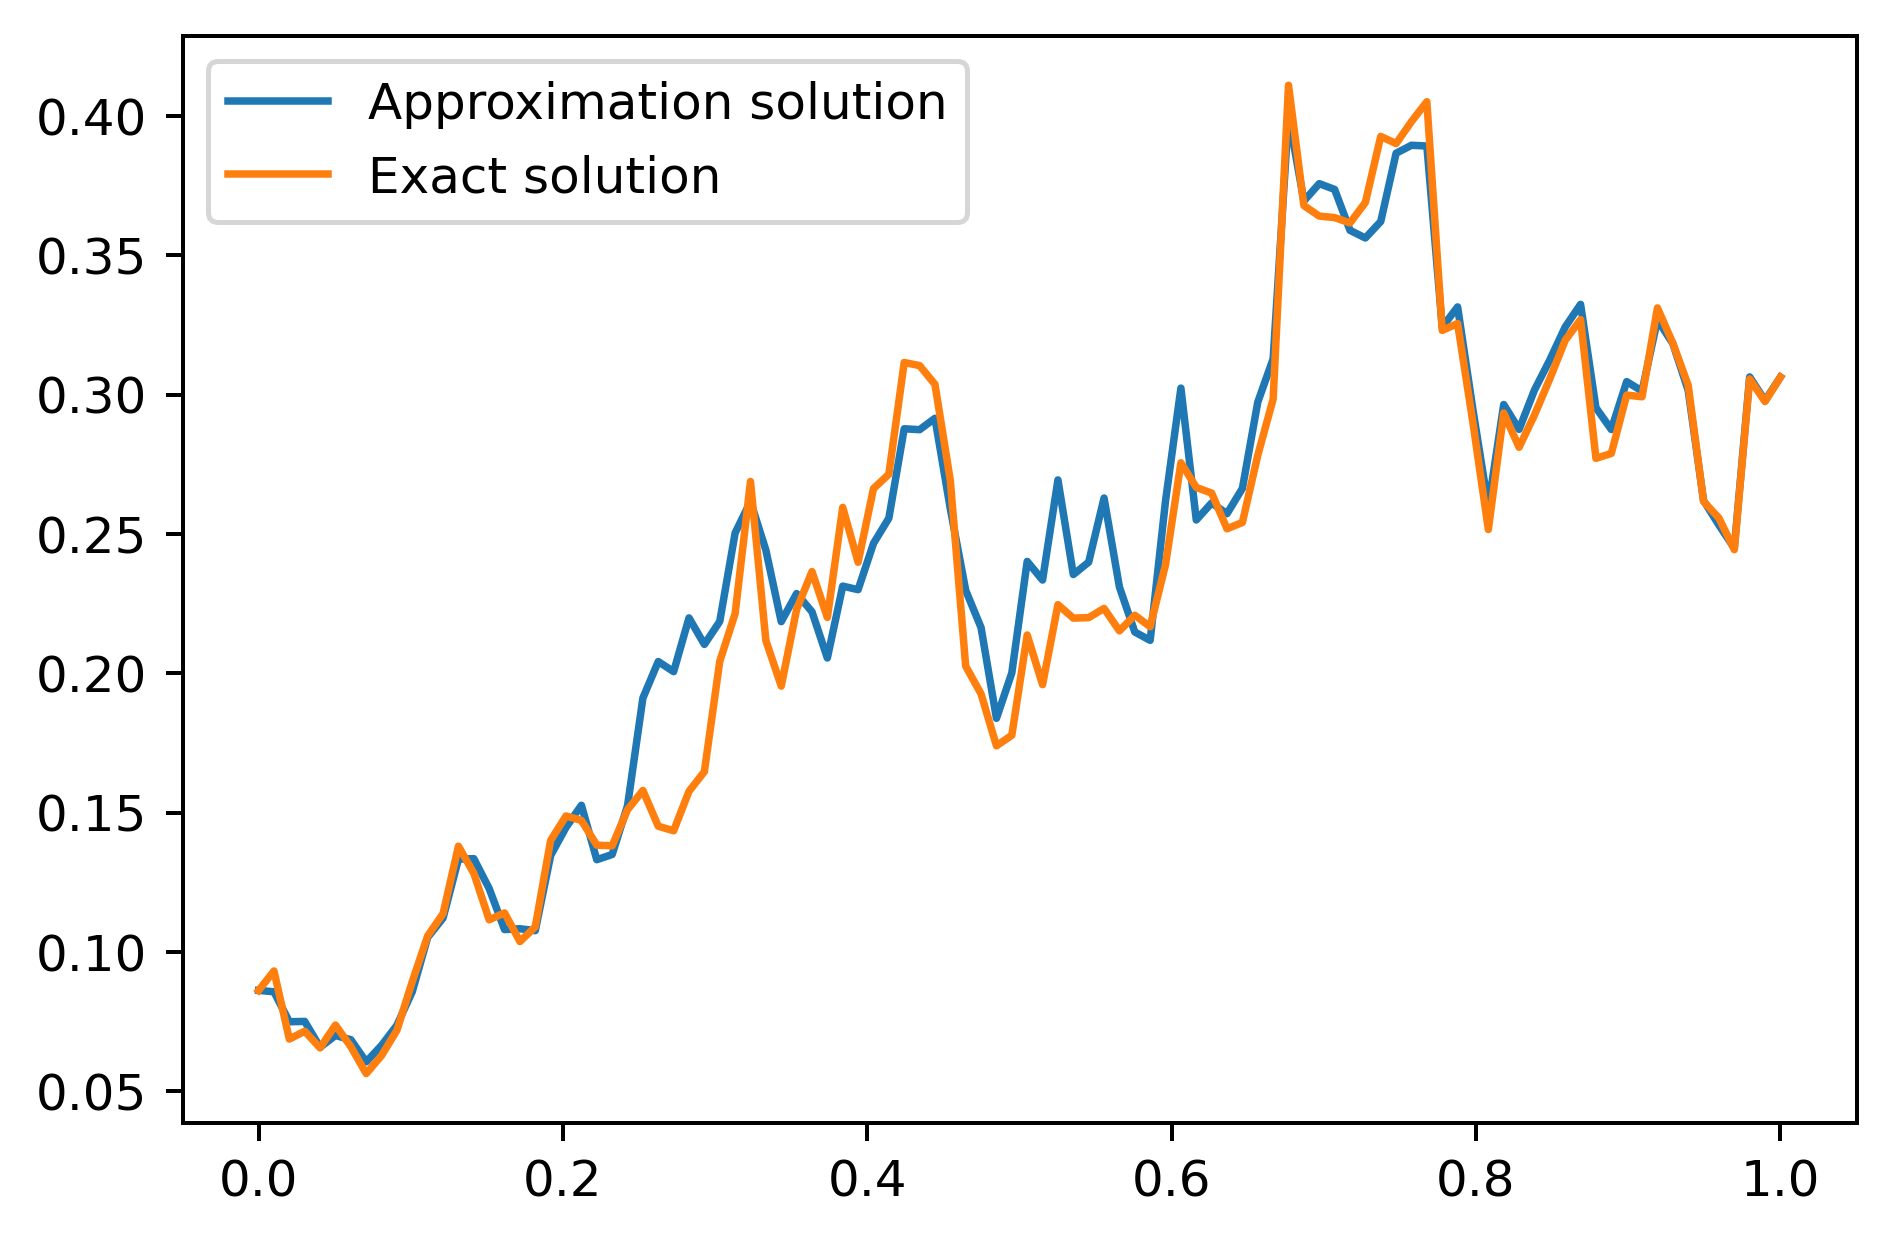

In [11]:
fig = plt.figure(1,dpi = 360) 
rnd_sample = np.random.randint(0,N_mc)
ax1=plt.subplot(111)   
l1,=ax1.plot(t,Y_df[rnd_sample])
l2,=ax1.plot(t,Ytrue_df[rnd_sample])
plt.legend(handles=[l1,l2,],labels=['Approximation solution','Exact solution'],loc='best')
plt.show()

In [12]:
error = 0
for i in range(N_mc):
    error += np.sum(np.power((Y_df[i]-Ytrue_df[i]),2))
    error = error/N_mc
print(f'The error is {error}')

The error is 7.161683511945187e-06


## Convergence test


### 1.Different Monte Carlo samples

#### Warning!  
The cell may take 1 minute to run

In [13]:
mc = [i*100 for i in range(1,31)]
test_error_mc = []
for i in range(0,30):
    dW_df, W_T, S_df = simulate_BM(N_mc=mc[i])
    Y_df, Ytrue_df, t, N_mc=  get_solution_BSDE(N_mc=mc[i])
    error = 0
    for i in range(N_mc):
        error += np.sum(np.power((Y_df[i]-Ytrue_df[i]),2))
        error = error/N_mc
    test_error_mc.append(error)

D:\Anaconda\lib\site-packages\numpy\polynomial\hermite_e.py:1371: RankWarning: The fit may be poorly conditioned
  return pu._fit(hermevander, x, y, deg, rcond, full, w)


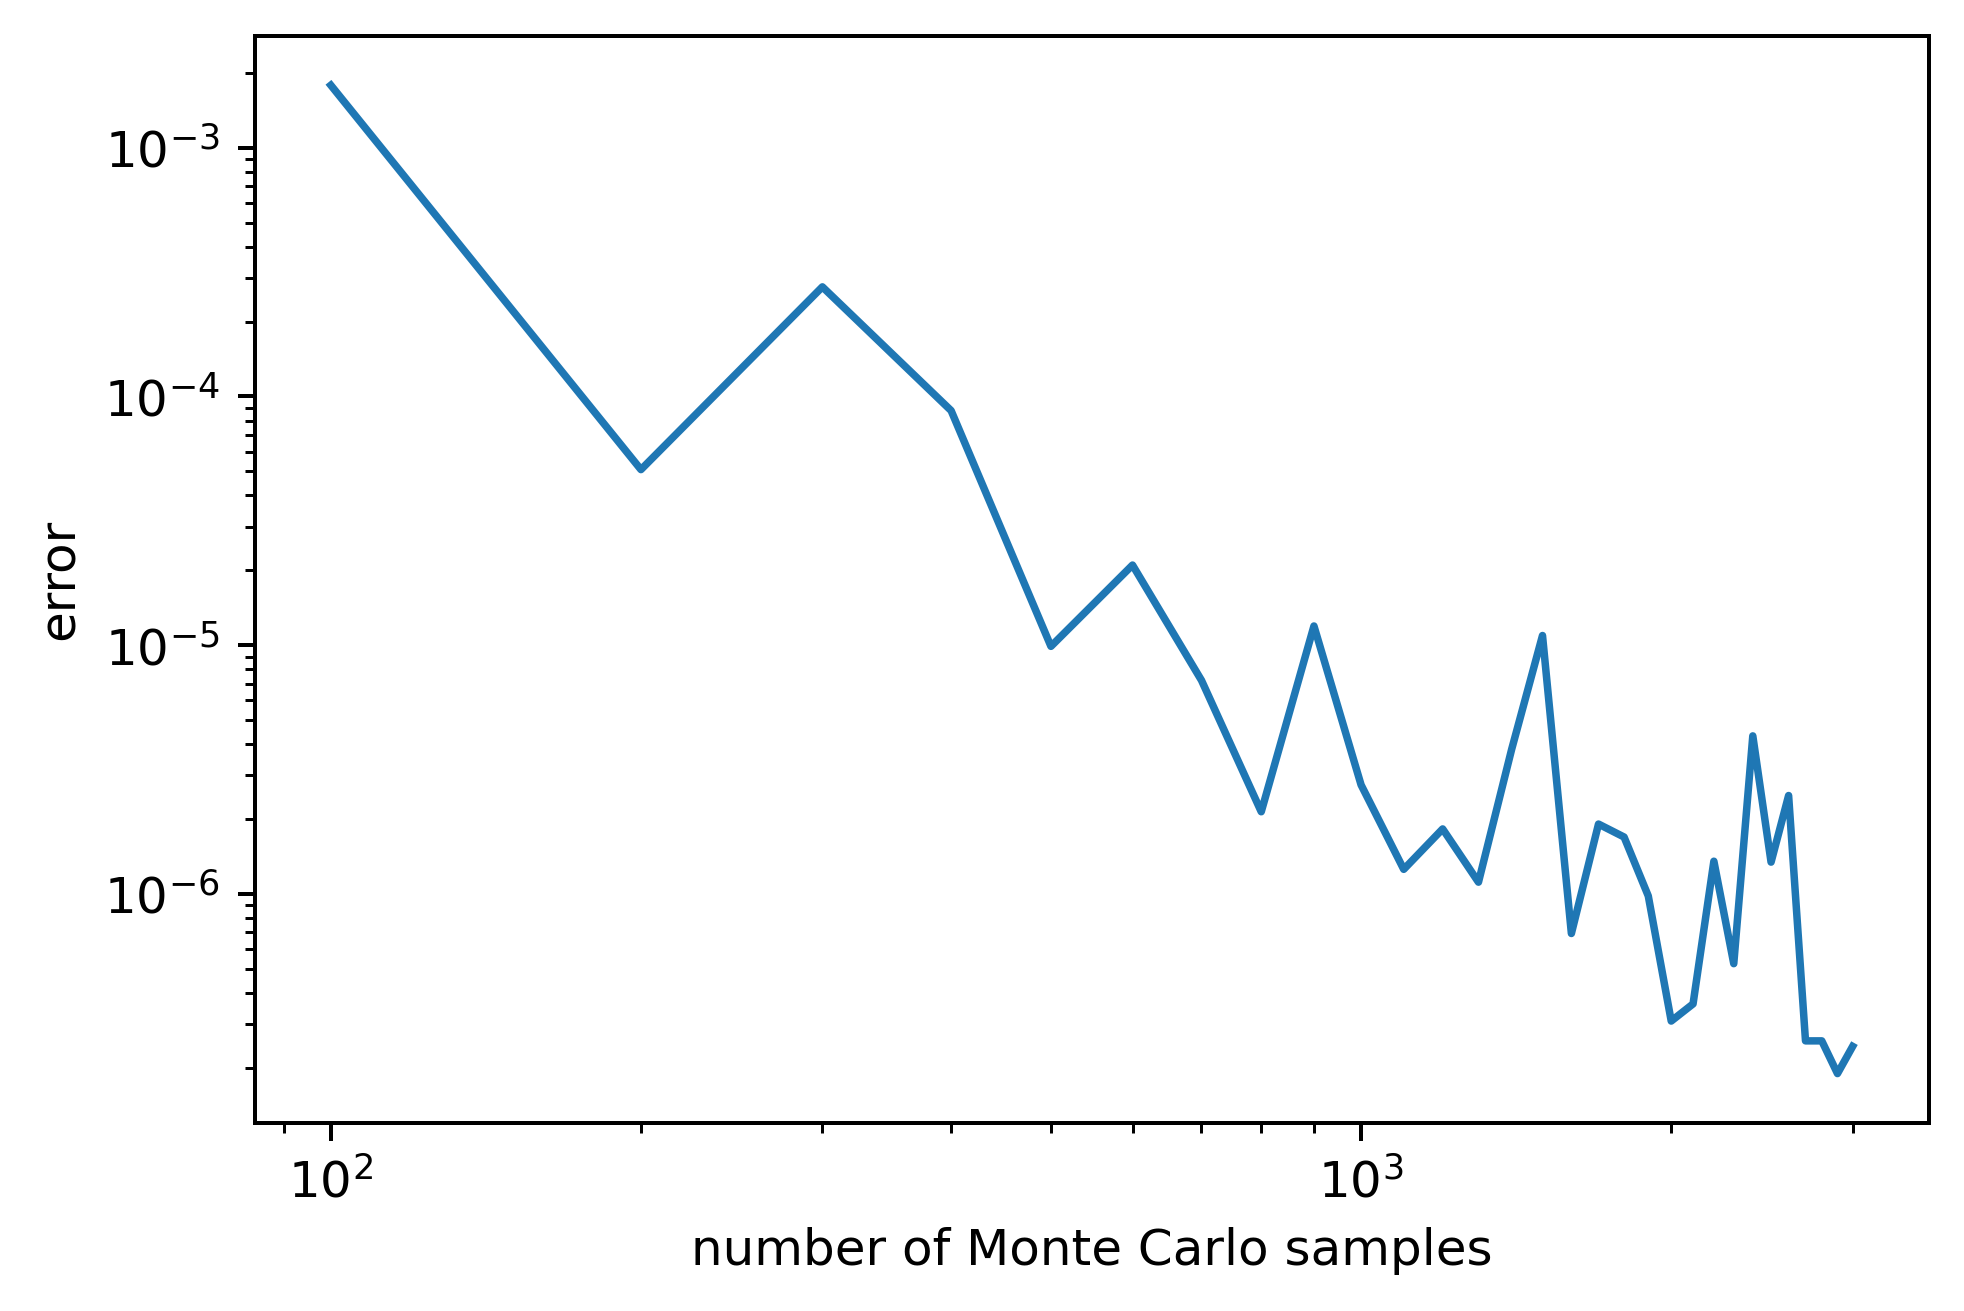

In [14]:
plt.figure(dpi=360)
plt.xlabel('number of Monte Carlo samples')
plt.ylabel('error')
plt.loglog(mc,test_error_mc)

## 2. Diiferent time step

#### Warning!  
The cell may take 3 minutes to run

In [15]:
ts = [i*35 for i in range(1,26)]
test_error_ts = []
for i in range(0,25):
    dW_df, W_T, S_df = simulate_BM(N=ts[i])
    Y_df, Ytrue_df, t, N_mc=  get_solution_BSDE(N=ts[i])
    error = 0
    for i in range(N_mc):
        error += np.sum(np.power((Y_df[i]-Ytrue_df[i]),2))
        error = error/N_mc
    test_error_ts.append(error)

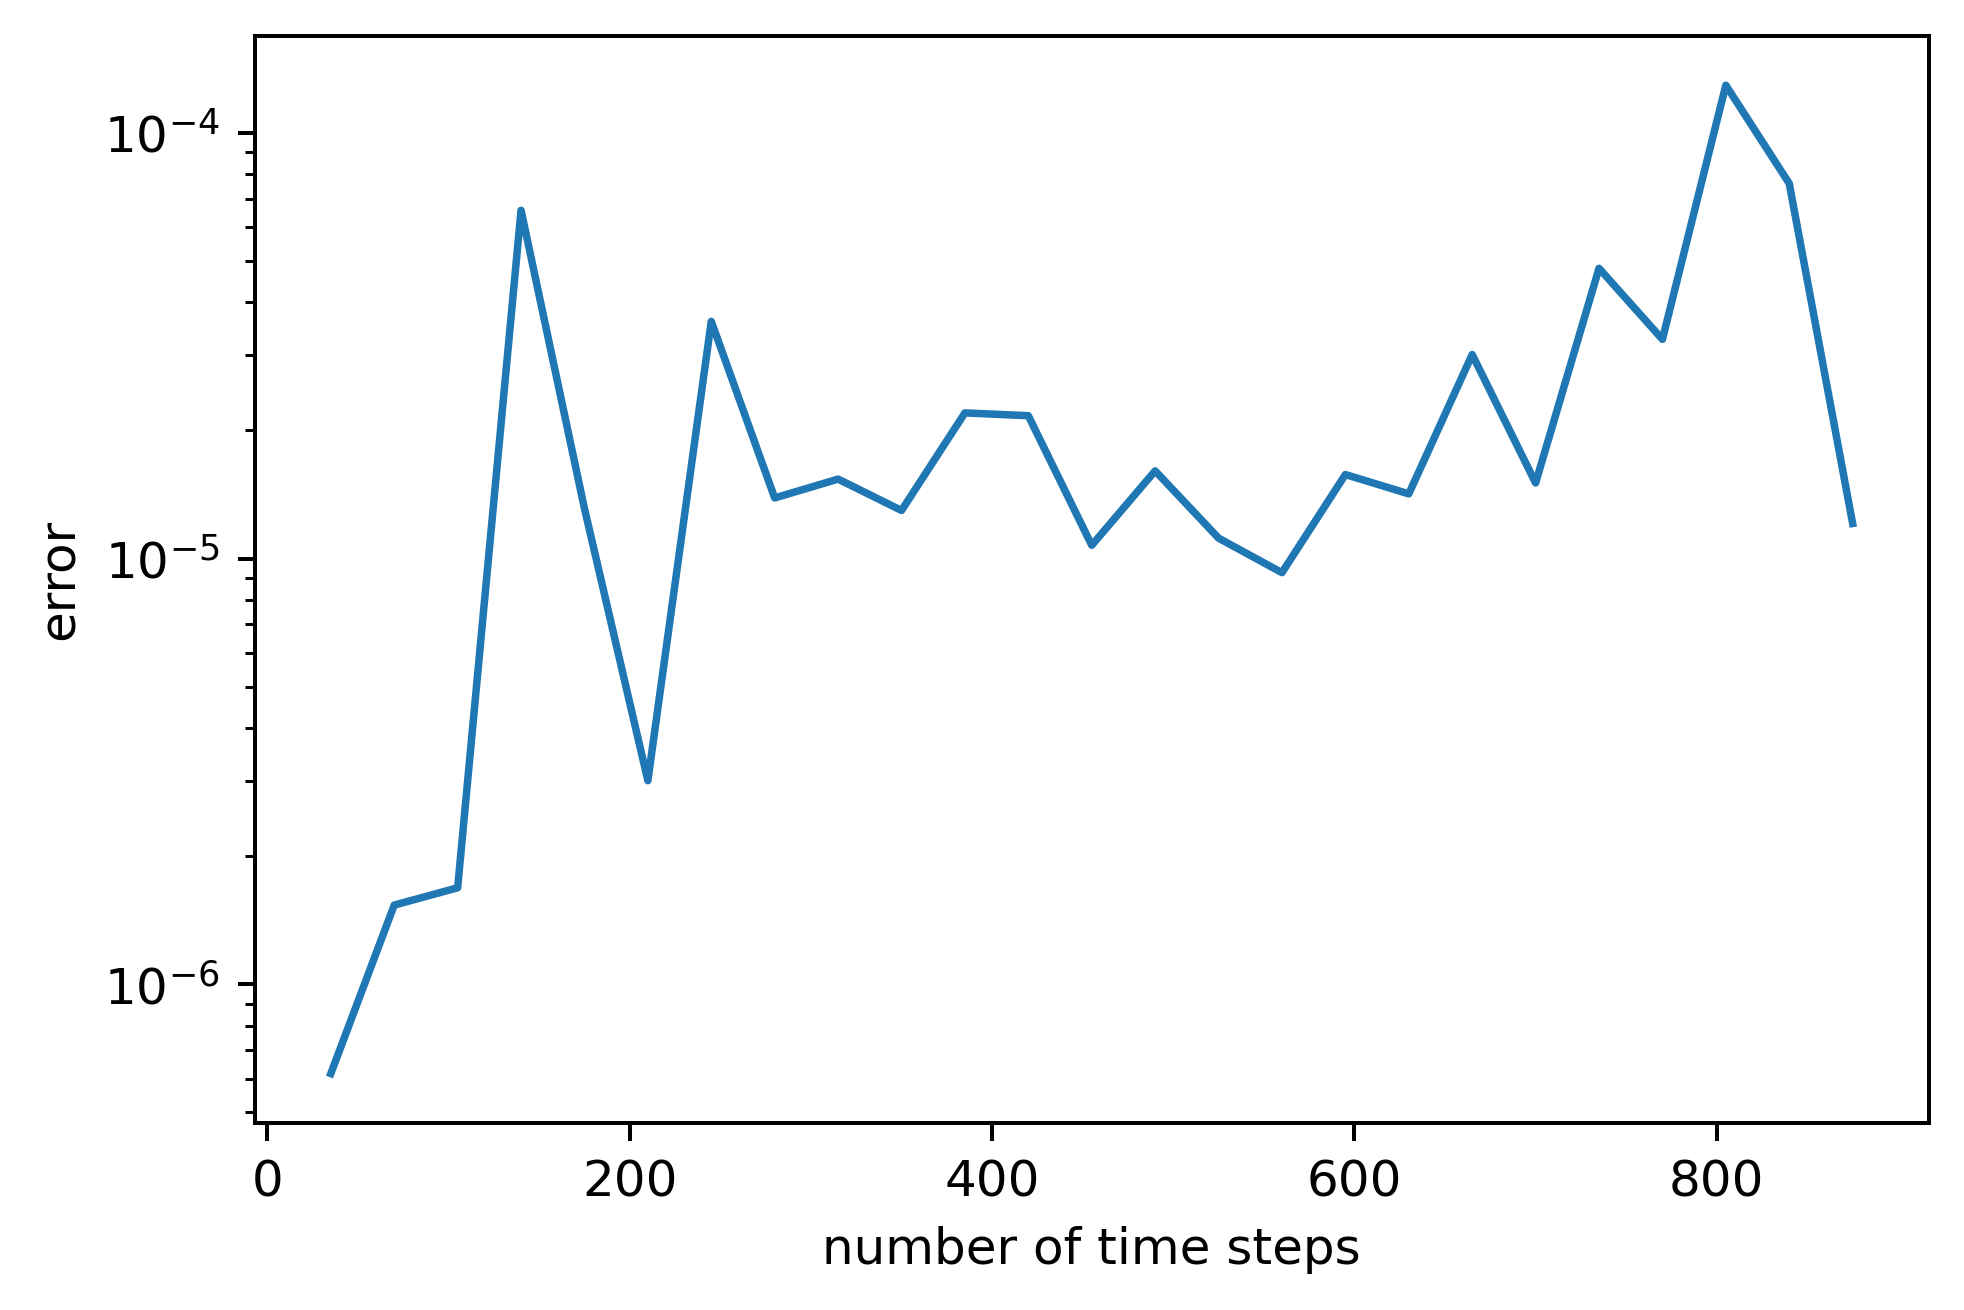

In [16]:
plt.figure(dpi=360)
plt.xlabel('number of time steps')
plt.ylabel('error')
plt.semilogy(ts,test_error_ts)

## 3. Different number of basis functions

#### Warning!  
The cell may take 2 minutes to run

In [17]:
basis = [i*10 for i in range(1,21)]
test_error_basis = []
for i in range(0,20):
    dW_df, W_T, S_df = simulate_BM()
    Y_df, Ytrue_df, t, N_mc=  get_solution_BSDE(N_basis_f=basis[i])
    error = 0
    for i in range(N_mc):
        error += np.sum(np.power((Y_df[i]-Ytrue_df[i]),2))
        error = error/N_mc
    test_error_basis.append(error)

D:\Anaconda\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
D:\Anaconda\lib\site-packages\numpy\polynomial\polyutils.py:706: RuntimeWarning: overflow encountered in square
  scl = np.sqrt(np.square(lhs).sum(1))


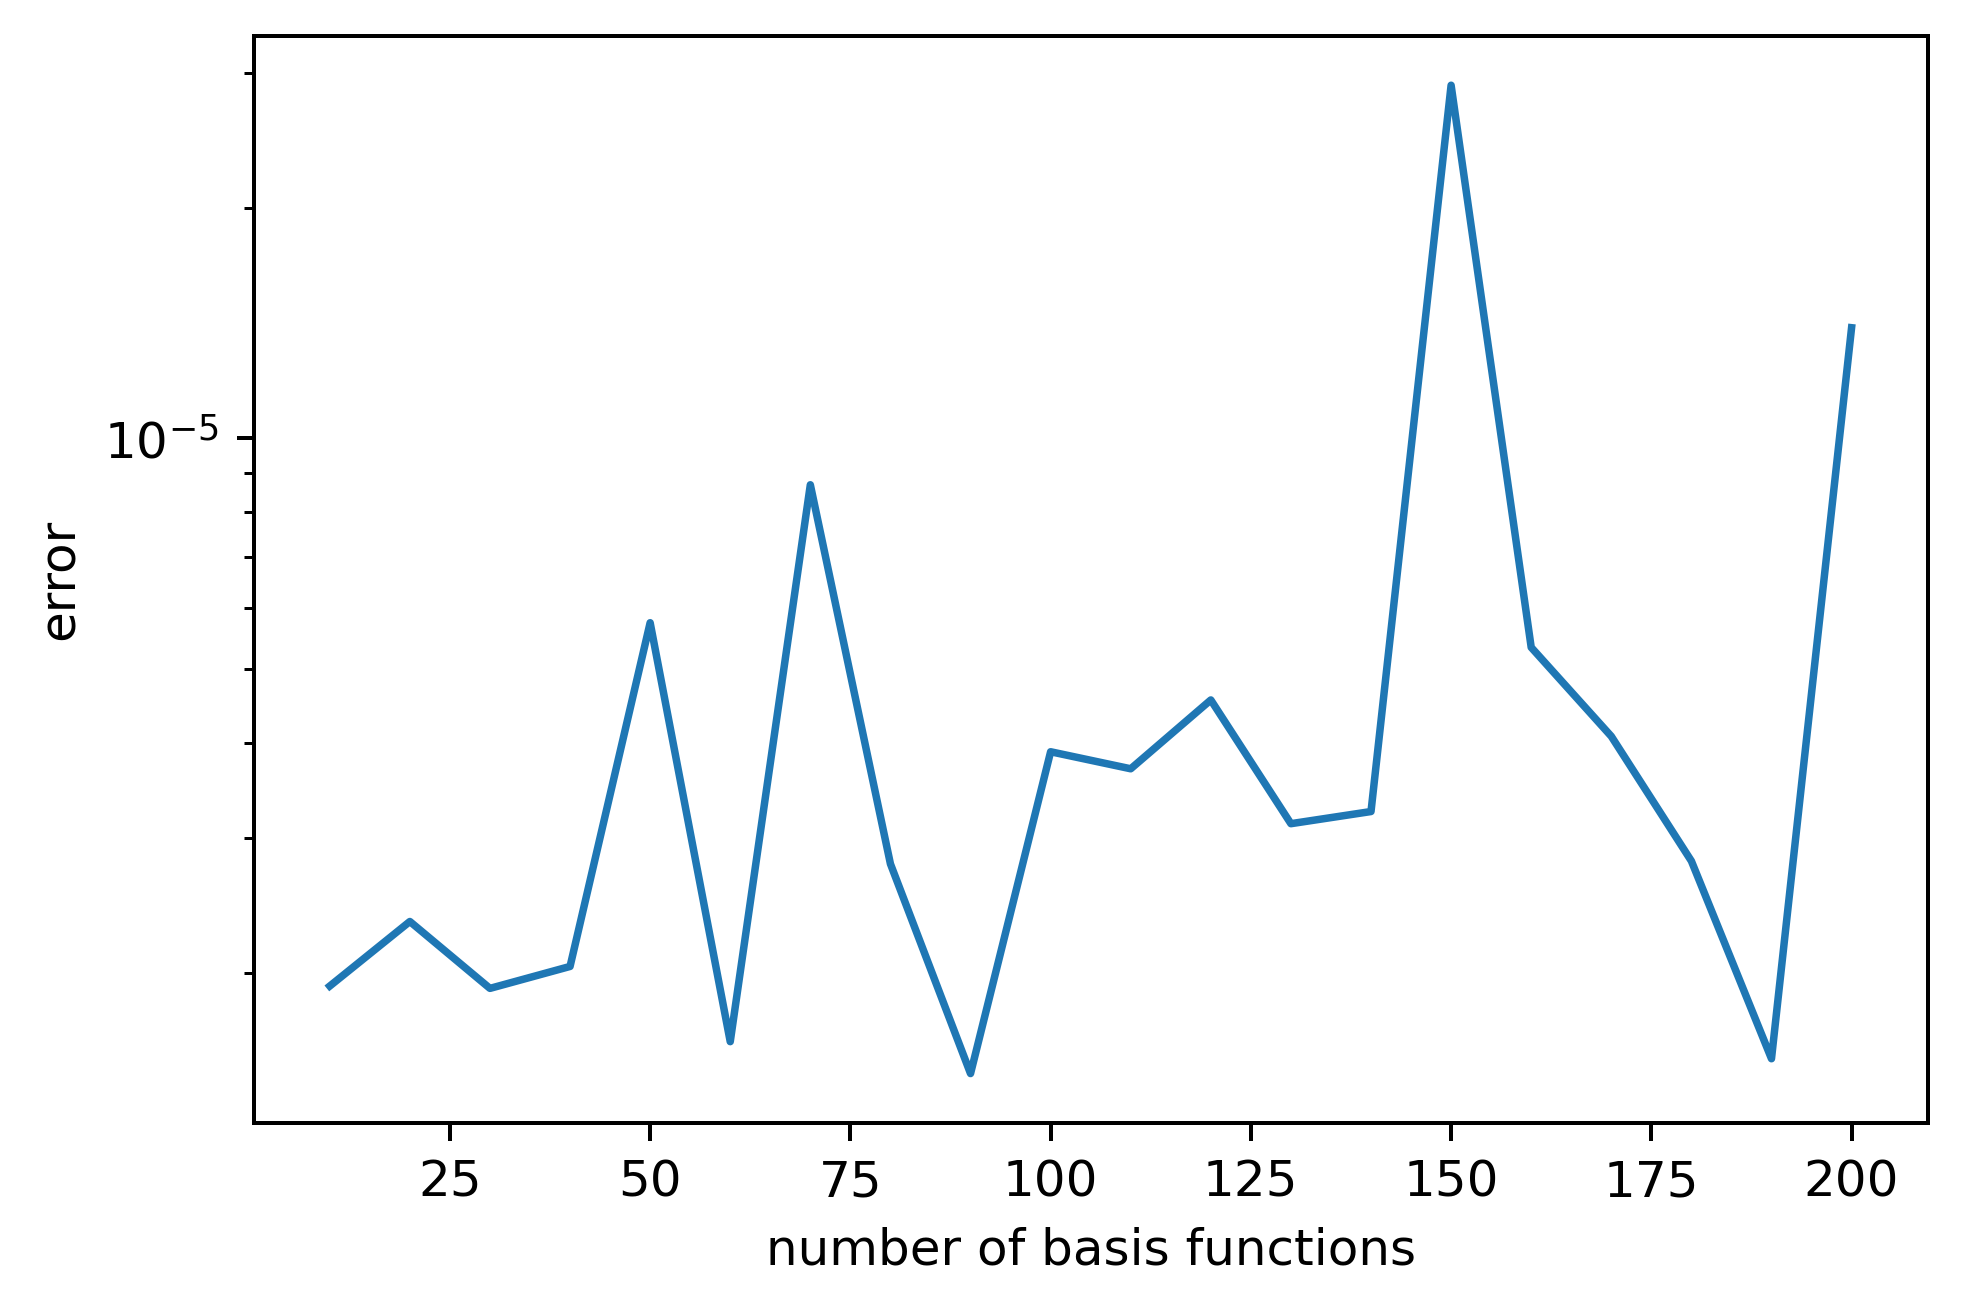

In [18]:
plt.figure(dpi=360)
plt.xlabel('number of basis functions')
plt.ylabel('error')
plt.semilogy(basis,test_error_basis)

### Comments

We can see that the more Monte Carlo samples, the lower error we have but with fluctuation. However, the overall trend is downward as the sample path increase.

For the time step, as the time step get smaller, the test error experience an upward trend with fluctuation

As for the different number of basis functions, we can make a really good approximation using 20 to 50 basis function, however, as the basis number goes up, the function may over-fitting the conditional expectation, which will increase the variance and the test erorr increase. 